# Simulador de Localiza√ß√£o de Centro de Distribui√ß√£o (Magalu)

Este notebook compara os custos de abrir um novo Centro de Distribui√ß√£o no **Recife (PE)** ou em **Salvador (BA)**, 
considerando:

1. **Custos imobili√°rios** (refer√™ncia: relat√≥rio RB Investimentos, 2025).  
2. **Custos log√≠sticos** ‚Äî calculados com base nas dist√¢ncias rodovi√°rias at√© as cidades do Nordeste com >150 mil habitantes.  
3. **Demanda de entregas** proporcional √† popula√ß√£o de cada cidade.  

O objetivo √© estimar qual localiza√ß√£o gera o **menor custo total** e em quanto tempo o investimento se paga.


In [19]:
# ****ATEN√á√ÉO**** 
# CASO J√Å TENHA PROCESSADO O C√ÅLCULO DAS DISTANCIAS ENTRE AS CIDADES
# E A TABELA ESTEJA SALVA: PULAR KERNELS INICIAIS (AT√â A UTILIZA√á√ÉO DO OpenRouteService)


# Neste bloco, vamos utilizar a tabela de dados demogr√°ficos do IBGE2025 
# para filtrar as cidades do nordeste com >150k habitantes
# link: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html
#(dispon√≠vel em xls para download no link abaixo, mas aqui j√° convertida para .csv)
import numpy as np
import pandas as pd

df_pop = pd.read_csv("estimativa_dou_2025.csv", sep=",")
df_pop.columns = df_pop.columns.str.strip()  # tira espa√ßos extras

df_pop.head()

UF  COD_UF  COD_MUN              MUNICIPIO      POP
0  RO    11.0     15.0  Alta Floresta D'Oeste   22.787
1  RO    11.0     23.0              Ariquemes  109.170
2  RO    11.0     31.0                 Cabixi    5.664
3  RO    11.0     49.0                 Cacoal   98.280
4  RO    11.0     56.0             Cerejeiras   16.966

In [21]:
# Alterando nomes das colunas e passando informa√ß√£o sobre a popula√ß√£o para tipo integer
# Remove espa√ßos no nome das colunas
df_pop.columns = df_pop.columns.str.strip()

# Converte para string, limpa pontos e remove NaN
df_pop["POP"] = (
    df_pop["POP"]
    .astype(str)                # garante string
    .str.replace(".", "", regex=False)  # tira pontos
    .str.strip()                # remove espa√ßos extras
)

# Remove linhas inv√°lidas (nan, vazio, etc.)
df_pop = df_pop[df_pop["POP"].str.isnumeric()].copy()

# Converte para inteiro
df_pop["POP"] = df_pop["POP"].astype(int)

# Renomeia colunas
df_pop = df_pop.rename(columns={
    "UF": "uf",
    "COD_UF": "cod_uf",
    "COD_MUN": "cod_municipio",
    "MUNICIPIO": "municipio",
    "POP": "populacao"
})

df_pop.head(), df_pop.dtypes

(   uf  cod_uf  cod_municipio              municipio  populacao
 0  RO    11.0           15.0  Alta Floresta D'Oeste      22787
 1  RO    11.0           23.0              Ariquemes     109170
 2  RO    11.0           31.0                 Cabixi       5664
 3  RO    11.0           49.0                 Cacoal      98280
 4  RO    11.0           56.0             Cerejeiras      16966,
 uf                object
 cod_uf           float64
 cod_municipio    float64
 municipio         object
 populacao          int64
 dtype: object)

In [22]:
# Aplica filtro para cidades do nordeste com >150k hab
ufs_ne = ["MA","PI","CE","RN","PB","PE","AL","SE","BA"]
df_ne = df_pop[df_pop["uf"].isin(ufs_ne)].copy()
df_ne150k = df_ne[df_ne["populacao"] > 150_000].reset_index(drop=True)

print("Total de cidades NE >150k habitantes:", len(df_ne150k))
df_ne150k.head()


Total de cidades NE >150k habitantes: 45


uf  cod_uf  cod_municipio            municipio  populacao
0  MA    21.0         3000.0               Caxias     163546
1  MA    21.0         5302.0           Imperatriz     285806
2  MA    21.0         7506.0       Pa√ßo do Lumiar     153158
3  MA    21.0        11201.0  S√£o Jos√© de Ribamar     259164
4  MA    21.0        11300.0             S√£o Lu√≠s    1089215

In [24]:
# agora vamos adicionar as coordenadas dessas cidades para posteriormente calcular as distancias
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="magalu_simulador")

latitudes, longitudes = [], []

for cidade, uf in zip(df_ne150k["municipio"], df_ne150k["uf"]):
    try:
        location = geolocator.geocode(f"{cidade}, {uf}, Brasil")
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except Exception as e:
        print(f"Erro ao geocodificar {cidade}-{uf}: {e}")
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  # respeitar limite do Nominatim

df_ne150k["lat"] = latitudes
df_ne150k["lon"] = longitudes

df_ne150k.head()


uf  cod_uf  cod_municipio            municipio  populacao       lat  \
0  MA    21.0         3000.0               Caxias     163546 -4.865420   
1  MA    21.0         5302.0           Imperatriz     285806 -5.526928   
2  MA    21.0         7506.0       Pa√ßo do Lumiar     153158 -2.532906   
3  MA    21.0        11201.0  S√£o Jos√© de Ribamar     259164 -2.560912   
4  MA    21.0        11300.0             S√£o Lu√≠s    1089215 -2.529526   

         lon  
0 -43.353664  
1 -47.478115  
2 -44.159197  
3 -44.055951  
4 -44.296394

In [25]:
# Salva o data frame em um novo arquivo
df_ne150k.to_csv("cidades_ne150k.csv", index=False)

In [26]:
# agora vamos calcular as distancias mais pr√≥ximas pelas rodovias dispon√≠veis utilizando o OpenRouteService
# Para ter uma chave para a API, √© necess√°rio ter uma conta no https://openrouteservice.org/ 
import requests
import time

# Defina sua chave da API ORS
ORS_API_KEY = "ADD YOUR API KEY HERE"

# Coordenadas das origens
coord_origens = {
    "recife":    (-34.8770, -8.0476),   # (lon, lat)
    "salvador":  (-38.5014, -12.9714),
}

def ors_distance(lon1, lat1, lon2, lat2, retries=3, sleep=1.5):
    url = "https://api.openrouteservice.org/v2/directions/driving-car"
    headers = {"Authorization": ORS_API_KEY, "Content-Type": "application/json"}
    body = {"coordinates": [[lon1, lat1], [lon2, lat2]]}
    for attempt in range(retries):
        try:
            r = requests.post(url, json=body, headers=headers, timeout=30)
            js = r.json()
            if "routes" in js:
                dist_km = js["routes"][0]["summary"]["distance"] / 1000
                tempo_h = js["routes"][0]["summary"]["duration"] / 3600
                return dist_km, tempo_h
        except Exception as e:
            print(f"Tentativa {attempt+1} falhou: {e}")
            time.sleep(sleep)
    return None, None

# Criar colunas de dist√¢ncia/tempo para cada origem
for origem, (olon, olat) in coord_origens.items():
    dists, tempos = [], []
    for _, row in df_ne150k.iterrows():
        if abs(row["lat"] - olat) < 1e-3 and abs(row["lon"] - olon) < 1e-3:
            dists.append(0.0)
            tempos.append(0.0)
        else:
            d, t = ors_distance(olon, olat, row["lon"], row["lat"])
            dists.append(d)
            tempos.append(t)
            time.sleep(0.2)  # respeitar API
    df_ne150k[f"dist_{origem}_km"] = dists
    df_ne150k[f"tempo_{origem}_h"] = tempos

df_ne150k.head()


uf  cod_uf  cod_municipio            municipio  populacao       lat  \
0  MA    21.0         3000.0               Caxias     163546 -4.865420   
1  MA    21.0         5302.0           Imperatriz     285806 -5.526928   
2  MA    21.0         7506.0       Pa√ßo do Lumiar     153158 -2.532906   
3  MA    21.0        11201.0  S√£o Jos√© de Ribamar     259164 -2.560912   
4  MA    21.0        11300.0             S√£o Lu√≠s    1089215 -2.529526   

         lon  dist_recife_km  tempo_recife_h  dist_salvador_km  \
0 -43.353664       1194.9111       14.601389         1218.7351   
1 -47.478115       1705.1704       22.250833         1728.9945   
2 -44.159197       1561.7015       19.905056         1585.5255   
3 -44.055951       1573.1005       20.072694         1596.9245   
4 -44.296394       1557.7181       19.800917         1581.5422   

   tempo_salvador_h  
0         15.905194  
1         23.554611  
2         21.208833  
3         21.376472  
4         21.104722

In [27]:
# salvar tabela:
df_ne150k.to_csv("cidades_ne150k.csv", index=False)

In [28]:
# SE A TABELA COM AS DISTANCIAS ENTRE AS CIDADES J√Å ESTIVER SALVA
# RODAR A PARTIR DAQUI! 
import pandas as pd

df_ne150k = pd.read_csv('cidades_ne150k.csv')
df_ne150k.head()

uf  cod_uf  cod_municipio            municipio  populacao       lat  \
0  MA    21.0         3000.0               Caxias     163546 -4.865420   
1  MA    21.0         5302.0           Imperatriz     285806 -5.526928   
2  MA    21.0         7506.0       Pa√ßo do Lumiar     153158 -2.532906   
3  MA    21.0        11201.0  S√£o Jos√© de Ribamar     259164 -2.560912   
4  MA    21.0        11300.0             S√£o Lu√≠s    1089215 -2.529526   

         lon  dist_recife_km  tempo_recife_h  dist_salvador_km  \
0 -43.353664       1194.9111       14.601389         1218.7351   
1 -47.478115       1705.1704       22.250833         1728.9945   
2 -44.159197       1561.7015       19.905056         1585.5255   
3 -44.055951       1573.1005       20.072694         1596.9245   
4 -44.296394       1557.7181       19.800917         1581.5422   

   tempo_salvador_h  
0         15.905194  
1         23.554611  
2         21.208833  
3         21.376472  
4         21.104722

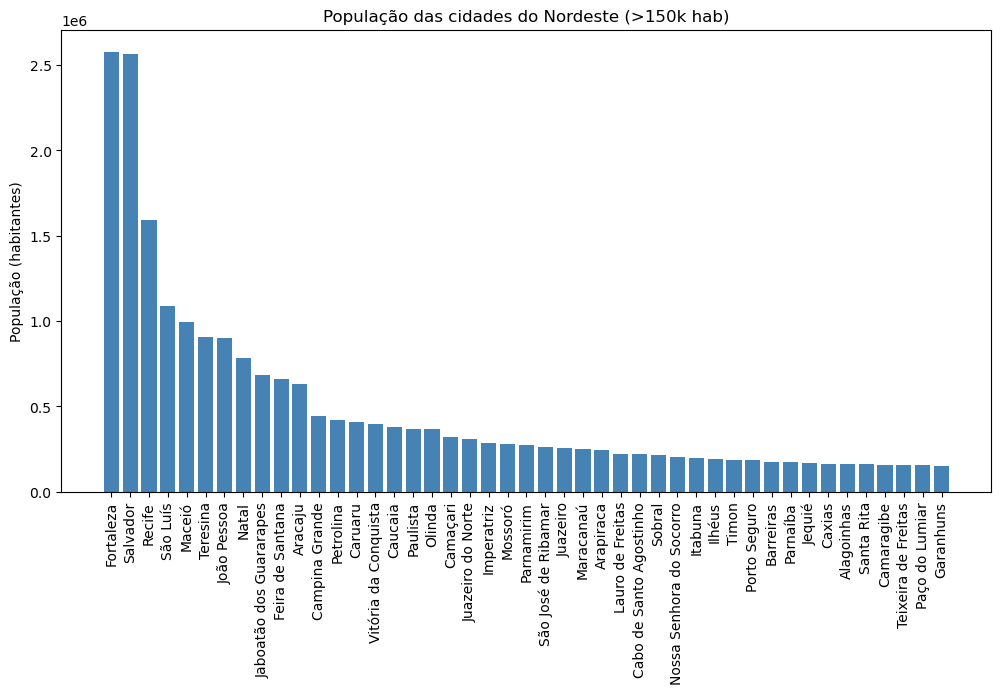

In [29]:
# Alguns plots para verificar dados obtidos at√© aqui
import matplotlib.pyplot as plt


# histograma: popula√ß√µes
df_ne150k_sorted = df_ne150k.sort_values("populacao", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(df_ne150k_sorted["municipio"], df_ne150k_sorted["populacao"], color="steelblue")
plt.xticks(rotation=90)
plt.ylabel("Popula√ß√£o (habitantes)")
plt.title("Popula√ß√£o das cidades do Nordeste (>150k hab)")
plt.show()


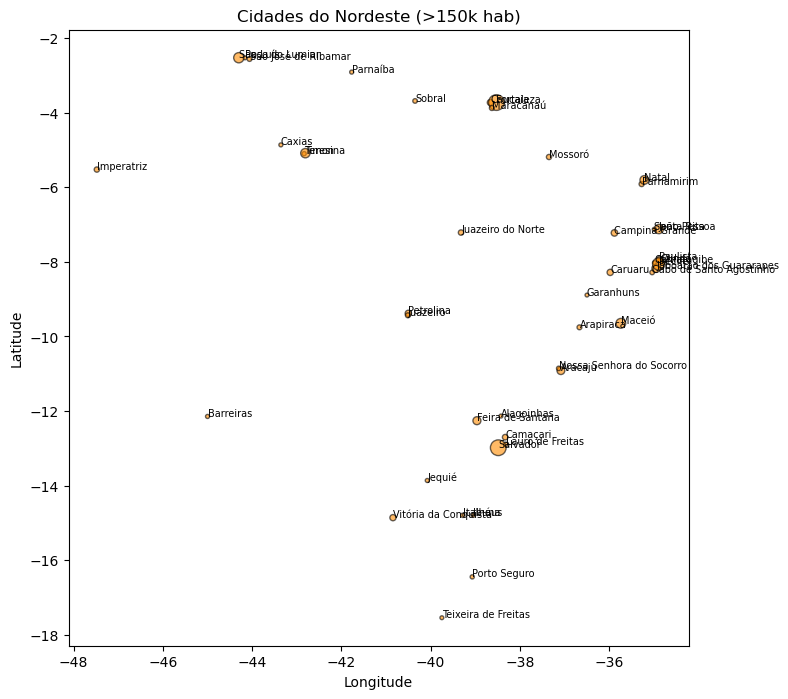

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(df_ne150k["lon"], df_ne150k["lat"], s=df_ne150k["populacao"]/20000, alpha=0.6, color="darkorange", edgecolor="k")

for _, row in df_ne150k.iterrows():
    plt.text(row["lon"], row["lat"], row["municipio"], fontsize=7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cidades do Nordeste (>150k hab)")
plt.show()


In [31]:
# Mapa interativo com a posi√ß√£o das cidades.
# tamanho do marcador √© proporcional √†s popula√ß√£o

import folium

# Centralizar o mapa no NE
m = folium.Map(location=[-9, -39], zoom_start=5)

for _, row in df_ne150k.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["populacao"]/200000,  # escala do tamanho
        popup=f"{row['municipio']} ({row['populacao']:,} hab)",
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(m)

m.save("mapa_cidades_ne150k.html")
m

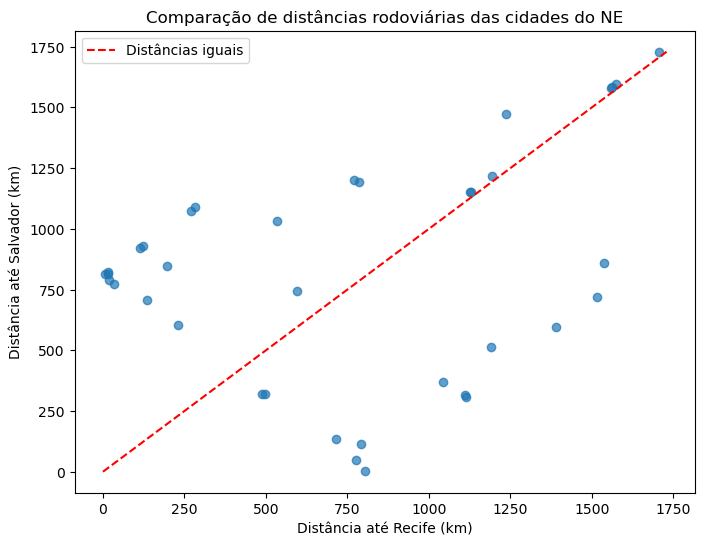

In [32]:
# Distancias recife vs. salvador 

plt.figure(figsize=(8,6))
plt.scatter(df_ne150k["dist_recife_km"], df_ne150k["dist_salvador_km"], alpha=0.7)

# Linha de refer√™ncia (onde dist√¢ncias seriam iguais)
max_val = max(df_ne150k["dist_recife_km"].max(), df_ne150k["dist_salvador_km"].max())
plt.plot([0, max_val], [0, max_val], "r--", label="Dist√¢ncias iguais")

plt.xlabel("Dist√¢ncia at√© Recife (km)")
plt.ylabel("Dist√¢ncia at√© Salvador (km)")
plt.title("Compara√ß√£o de dist√¢ncias rodovi√°rias das cidades do NE")
plt.legend()
plt.show()


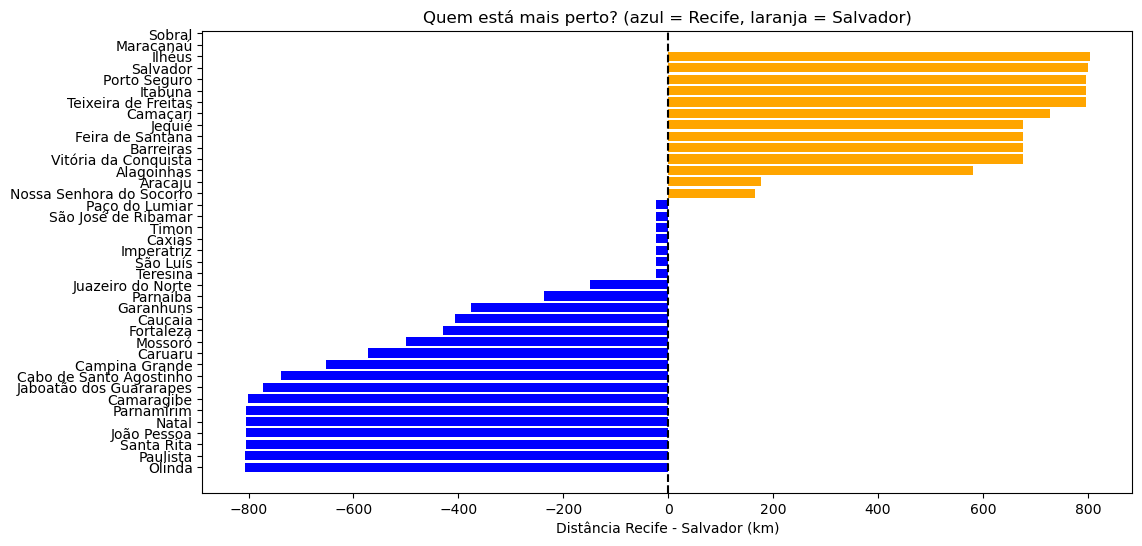

In [33]:
# Distancia de recife *menos* distancia de salvador
# qual p√≥lo est√° mais pr√≥ximo?
df_ne150k["delta_km"] = df_ne150k["dist_recife_km"] - df_ne150k["dist_salvador_km"]

df_sorted = df_ne150k.sort_values("delta_km")

plt.figure(figsize=(12,6))
plt.barh(df_sorted["municipio"], df_sorted["delta_km"], color=df_sorted["delta_km"].apply(lambda x: "blue" if x < 0 else "orange"))
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Dist√¢ncia Recife - Salvador (km)")
plt.title("Quem est√° mais perto? (azul = Recife, laranja = Salvador)")
plt.show()


## C√°lculos log√≠sticos

- **Para cidades ‚â† origem:**  
  `custo = entregas √ó dist√¢ncia_rodovi√°ria √ó custo_km`

- **Para a cidade da origem:**  
  `custo = entregas √ó km_intra_urbano (15 km) √ó custo_km`

---

**Pondera√ß√£o pelas popula√ß√µes:**  
Os c√°lculos de entregas ser√£o ponderados pelo n√∫mero de habitantes de cada cidade.  
Por exemplo, se tivermos **1000 entregas** em um dado per√≠odo, esse n√∫mero ser√° dividido proporcionalmente entre todas as cidades do Nordeste consideradas nesta an√°lise.

O pre√ßo imobili√°rio de cada cidade (Salvador ou Recife) de galp√µes log√≠sticos tamb√©m ser√° levado em considera√ß√£o para avaliarmos o payback.

---

**Par√¢metros iniciais (ajust√°veis conforme a necessidade):**
- `n_entregas`: n√∫mero total de entregas no per√≠odo
- `custo_km`: custo m√©dio por km por entrega (Reais/km)
- `km_intra_urbano`: dist√¢ncia m√©dia para last-mile na cidade da origem (km)
- `preco_m2_recife`: pre√ßo m√©dio por m¬≤ em Recife (Reais/m¬≤) - retirado do relat√≥rio RB investimentos para galp√µes log√≠sticos (https://www.rbinvestimentos.com/wp-content/uploads/2025/05/Galpoes-Logisticos-1.pdf)
- `preco_m2_salvador`: pre√ßo m√©dio por m¬≤ em Salvador (Reais/m¬≤) - retirado do relat√≥rio RB investimentos para galp√µes log√≠sticos (https://www.rbinvestimentos.com/wp-content/uploads/2025/05/Galpoes-Logisticos-1.pdf)
- `cd_area_m2`: √°rea total do centro de distribui√ß√£o (m¬≤)



origem custo_logistico_mes custo_fixo_imobiliario_mes custo_total_mes  \
0    Recife       R$ 36,511,716                 R$ 205,000   R$ 36,716,716   
1  Salvador       R$ 39,984,388                 R$ 295,000   R$ 40,279,388   

   dist_media_ponderada_km  
0               730.234320  
1               798.215613


 N√∫mero de entregas no m√™s: 50,000

üí∞ Diferen√ßa mensal (Salvador - Recife): R$ 3,562,672
üìâ Economia percentual ao escolher Recife: 8.84%


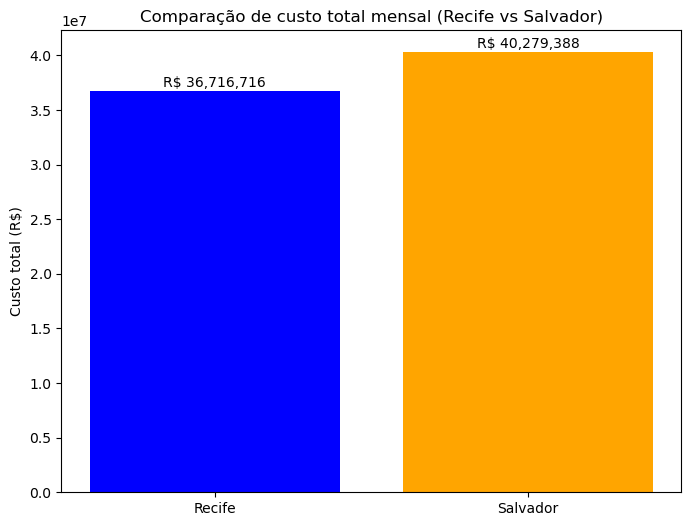

In [43]:
import numpy as np
import pandas as pd

# -------------------------
# Par√¢metros escolhidos pelo usu√°rio
# -------------------------
n_entregas  = 50_000   # total de entregas/m√™s (ajuste livre)
custo_km    = 1.00      # R$/km por entrega (combust√≠vel + motorista + manuten√ß√£o)
km_intra_urbano = 15.0  # km m√©dios por entrega dentro da cidade da origem (last-mile urbano)

# Custos imobili√°rios (RB Investimentos, CD de 10.000 m¬≤)
cd_area_m2 = 10_000
preco_m2_recife   = 20.5   # R$/m¬≤
preco_m2_salvador = 29.5   # R$/m¬≤
custo_fix_recife   = cd_area_m2 * preco_m2_recife
custo_fix_salvador = cd_area_m2 * preco_m2_salvador

# -------------------------
# Preparos
# -------------------------
df = df_ne150k.copy()

# Seguran√ßa: se houver dist√¢ncias faltantes, descarta para n√£o quebrar a simula√ß√£o
cols_need = ["dist_recife_km","dist_salvador_km","populacao","municipio","uf"]
df = df.dropna(subset=cols_need).reset_index(drop=True)

# Total populacional para pondera√ß√£o de demanda
total_pop = df["populacao"].sum()

def simular_para_origem(df_cidades, origem_nome, coluna_dist_km, custo_fixo_origem,
                        n_entregas, custo_km, km_intra_urbano):
    """
    origem_nome: "Recife" ou "Salvador" (como aparece em df['municipio'])
    coluna_dist_km: "dist_recife_km" ou "dist_salvador_km"
    """
    df_sim = df_cidades.copy()

    # entregas proporcionais √† popula√ß√£o
    df_sim["entregas"] = n_entregas * (df_sim["populacao"] / total_pop)

    # dist√¢ncia ajustada: se a cidade == origem, usar km_intra_urbano; sen√£o, usar a dist√¢ncia rodovi√°ria
    df_sim["dist_ajustada_km"] = np.where(
        df_sim["municipio"].str.lower() == origem_nome.lower(),
        km_intra_urbano,
        df_sim[coluna_dist_km]
    )

    # custo log√≠stico por cidade
    df_sim["custo_logistico"] = df_sim["entregas"] * df_sim["dist_ajustada_km"] * custo_km

    custo_log_total = df_sim["custo_logistico"].sum()
    custo_total = custo_log_total + custo_fixo_origem

    # m√©tricas auxiliares √∫teis
    dist_media_ponderada = (df_sim[coluna_dist_km] * df_sim["populacao"]).sum() / df_sim["populacao"].sum()
    dist_media_ponderada = float(dist_media_ponderada)

    resumo = {
        "origem": origem_nome,
        "custo_logistico": custo_log_total,
        "custo_fixo_imobiliario": custo_fixo_origem,
        "custo_total": custo_total,
        "dist_media_ponderada_km": dist_media_ponderada,
        "n_entregas": n_entregas,
        "custo_km": custo_km,
        "km_intra_urbano": km_intra_urbano,
    }
    return resumo, df_sim[["municipio","uf","populacao","entregas","dist_ajustada_km","custo_logistico"]]

# -------------------------
# Rodar simula√ß√£o para Recife e para Salvador
# -------------------------
res_rec, det_rec = simular_para_origem(
    df, "Recife", "dist_recife_km", custo_fix_recife,
    n_entregas, custo_km, km_intra_urbano
)

res_sal, det_sal = simular_para_origem(
    df, "Salvador", "dist_salvador_km", custo_fix_salvador,
    n_entregas, custo_km, km_intra_urbano
)

# Comparativo em DataFrame
comparativo = pd.DataFrame([res_rec, res_sal])

# Calcular diferen√ßa e economia percentual
custo_recife = res_rec["custo_total"]
custo_salvador = res_sal["custo_total"]

diff_mensal = custo_salvador - custo_recife
economia_pct = (diff_mensal / custo_salvador) * 100

comparativo["custo_total_mes"] = comparativo["custo_total"].map(lambda x: f"R$ {x:,.0f}")
comparativo["custo_logistico_mes"] = comparativo["custo_logistico"].map(lambda x: f"R$ {x:,.0f}")
comparativo["custo_fixo_imobiliario_mes"] = comparativo["custo_fixo_imobiliario"].map(lambda x: f"R$ {x:,.0f}")

display(comparativo[[
    "origem",
    "custo_logistico_mes",
    "custo_fixo_imobiliario_mes",
    "custo_total_mes",
    "dist_media_ponderada_km"
]])

print(f"\n N√∫mero de entregas no m√™s: {n_entregas:,.0f}")
print(f"\nüí∞ Diferen√ßa mensal (Salvador - Recife): R$ {diff_mensal:,.0f}")
print(f"üìâ Economia percentual ao escolher Recife: {economia_pct:.2f}%")

# --- Gr√°fico de barras
plt.figure(figsize=(8,6))
plt.bar(["Recife","Salvador"], [custo_recife, custo_salvador], color=["blue","orange"])
plt.ylabel("Custo total (R$)")
plt.title("Compara√ß√£o de custo total mensal (Recife vs Salvador)")

# valores acima das barras
for i, v in enumerate([custo_recife, custo_salvador]):
    plt.text(i, v + v*0.01, f"R$ {v:,.0f}", ha="center", fontsize=10)

plt.show()

# As tabelas detalhadas (se quiser inspecionar por cidade)
# det_rec.head(), det_sal.head()


## Interpreta√ß√£o dos Resultados

Ap√≥s rodar a simula√ß√£o, o notebook gera um comparativo entre **Recife** e **Salvador** como locais potenciais para o novo Centro de Distribui√ß√£o (CD).

### Sa√≠das principais:
- **Custo log√≠stico total**: resultado do transporte rodovi√°rio entre a origem e as demais cidades do Nordeste (ponderado pela popula√ß√£o de cada destino).
- **Custo fixo imobili√°rio**: custo mensal de aluguel do CD, considerando os valores de refer√™ncia da RB Investimentos (R$/m¬≤).
- **Custo total**: soma do custo log√≠stico e do custo fixo imobili√°rio.
- **Dist√¢ncia m√©dia ponderada**: dist√¢ncia m√©dia das rotas Recife/Salvador at√© as cidades do Nordeste, levando em conta o peso demogr√°fico de cada cidade.

### Como interpretar:
- Se o **custo total em Recife < Salvador**, ent√£o **Recife √© mais vantajoso** no cen√°rio analisado (e vice-versa).
- A coluna de **diferen√ßa mensal** mostra a economia estimada por m√™s.
- A **economia percentual** permite entender a magnitude da vantagem (ex.: ‚ÄúRecife √© 18% mais barato que Salvador‚Äù).
- A partir da economia mensal, √© poss√≠vel calcular o **payback**:  
  - Se a escolha mais cara tiver alguma vantagem estrat√©gica (estoque maior, incentivos fiscais, etc.), o payback mostra em quanto tempo esse custo adicional seria compensado ou se justifica.

### Observa√ß√£o importante:
Este modelo √© **param√©trico** ‚Äî ou seja, os resultados mudam se alterarmos:
- `n_entregas` (escala da opera√ß√£o),
- `custo_km` (varia√ß√£o no custo do transporte),
- `km_intra_urbano` (last-mile nas cidades de origem),
- ou o **pre√ßo/m¬≤** considerado para cada CD.

Assim, o notebook pode ser usado para **testar diferentes cen√°rios** e apoiar a tomada de decis√£o com base em dados.
